### the code presented in this notebook performs LinearRegression() model training and analysis for identification of the most influential factors affecting Russell 2000 closing prices

#### assumptions | analysis rationale:
<font color="blue">From a data perspective, our objective is to identify the crucial predictors influencing the pricing of Russell 2000. In line with the CRISP-DM methodology, this translates into formulating a predictive modeling challenge aimed at uncovering the significant features that contribute to variations in Russell 2000 prices. This involves leveraging statistical techniques and machine learning algorithms to analyze the dataset, extract meaningful patterns, and develop a predictive model that accurately estimates the price of the index based on its attributes.</font>

<font color="blue">To get familiar with the dataset and identify any quality issues, we will perform the following steps:</font>

1. we'll explore the data by loading it and analyzing the dataset using functions like `head()`, `info()`, `describe()` among other build-in methods
2. we'll examine each column individually to understand the type of data it contains
3. we'll identify missing values in the dataset and determine further strategy handling missing data, such as imputation or removal, based on the nature of the data corruption and its potential impact on the analysis
4. we'll look into any inconsistencies, errors, or anomalies in the data (this could include duplicate records, incorrect data types, inconsistent formatting, or unexpected values)
5. we'll explore relationships between different features in the dataset by utilizing visualization techniques like scatter plots, histograms, and correlation matrices
6. we'll incorporate financial markets domain knowledge to guide our exploration
7. and, finally we'll keep track of your observations, findings, and any actions taken during the data exploration process.
    
<font color="blue">Here I'd like to mention data transformations steps that will take place:
    * we'll use OneHotEncoder() and/or LabelEncoder() and/or StandardScaler() on the as-needed basis
    
<font color="blue">We will attempt to use the following models: LinearRegression(), Ridge(), and GridSearchCV() for cross-validation and best alpha parameter search

<font color="blue">After instantiating and training the models, we will evaluate our results via MSEs for training and testing data along with coefficients obtained for each feature in our dataset; coefficients will provide as the answer we're looking for - a meaningful insight on which features drive the Russell 2000 prices the most (effectively answering the ask of this AI modeling "What drives the price of the Russell 2000 index?")

<font color="blue">After completing our work we will deliver our findings via the report that will detail our insights and reccomendations to a group of options traders interested in fine-tuning their trading strategies</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

In [100]:
insight_df = pd.read_csv('C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/russell_2000_frequency_B.csv')

... starting to analyze the data and performing pre-processing tasks as needed

In [101]:
insight_df.head()

,Date,Open,High,Low,Close,Adj Close,Range,daily_delta,percentage_delta,Volume,Event,Category
0,1/6/2020,1650.660034,1664.849976,1645.510010,1663.260010,1663.260010,19.339966,2.390015,0.143901,3702460000,0,0
1,1/7/2020,1659.729980,1662.099976,1653.329956,1658.310059,1658.310059,8.770020,-4.949951,-0.297605,3435910000,0,0
2,1/8/2020,1658.469971,1669.290039,1658.229980,1663.589966,1663.589966,11.060059,5.279907,0.318391,3726840000,0,0
3,1/9/2020,1669.859985,1671.819946,1663.780029,1664.989990,1664.989990,8.039917,1.400024,0.084157,3641230000,0,0
4,1/10/2020,1665.469971,1666.750000,1654.010010,1657.640015,1657.640015,12.739990,-7.349975,-0.441443,3214580000,0,0


In [102]:
insight_df.tail()

,Date,Open,High,Low,Close,Adj Close,Range,daily_delta,percentage_delta,Volume,Event,Category
1090,3/11/2024,2075.739990,2079.969971,2063.780029,2065.879883,2065.879883,16.189942,-16.830078,-0.808086,3896430000,0,0
1091,3/12/2024,2066.149902,2072.949951,2052.929932,2065.479980,2065.479980,20.020019,-0.399903,-0.019358,4080510000,0,0
1092,3/13/2024,2062.750000,2080.189941,2062.350098,2071.709961,2071.709961,17.839843,6.229981,0.301624,4282890000,0,0
1093,3/14/2024,2064.280029,2064.280029,2017.280029,2031.180054,2031.180054,47.000000,-40.529907,-1.956350,4687970000,0,0
1094,3/15/2024,2020.630005,2041.880005,2018.949951,2039.319946,2039.319946,22.930054,8.139892,0.400747,7753670000,1,0


In [103]:
# dropping the 'Adj close' column since it is identical to 'Close' column + renaming 'Close' for easier interpretation
insight_df.drop('Adj Close', axis=1, inplace=True)
insight_df.rename(columns={'Close': 'closing_price'}, inplace=True)

In [104]:
# running diagnostic for how russell_2000 dataframe looks like now
print(insight_df.info())
print(type(insight_df))
print(len(insight_df))
print(insight_df.shape)
print(insight_df.dtypes) # this is covered by .info() function, but running it to double confirm expected output
insight_df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1095 non-null   object 
 1   Open              1095 non-null   float64
 2   High              1095 non-null   float64
 3   Low               1095 non-null   float64
 4   closing_price     1095 non-null   float64
 5   Range             1095 non-null   float64
 6   daily_delta       1095 non-null   float64
 7   percentage_delta  1095 non-null   float64
 8   Volume            1095 non-null   int64  
 9   Event             1095 non-null   int64  
 10  Category          1095 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 94.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
1095
(1095, 11)
Date                 object
Open                float64
High                float64
Low                 float64
closing_price       float64
Range               

,Date,Open,High,Low,closing_price,Range,daily_delta,percentage_delta,Volume,Event,Category
720,10/10/2022,1706.160034,1706.829956,1681.97998,1691.920044,24.849976,-10.22998,-0.601003,3834320000,0,0


In [105]:
# checking for missing values in data to determine the possibility of dropping them in order to make data cleaner
# data looks great!
insight_df.isna().sum()

Date                0
Open                0
High                0
Low                 0
closing_price       0
Range               0
daily_delta         0
percentage_delta    0
Volume              0
Event               0
Category            0
dtype: int64

In [106]:
# let's calculate the number of unique values for each 'object' type column in our dataframe to make further data pre-processing decisions
# it appears that there are 1095 uniques values in 'Date' column which makes total sense, since data is sequenced on a 5 business days cadence
# so we're dealing with 1095/5 = 219 weeks of data
# looping through columns
unique_counts = {}
categorical_columns = []

for i in insight_df.columns:
    if insight_df[i].dtype == 'object':
        unique_counts[i] = len(insight_df[i].unique())
        categorical_columns.append(i)

print(unique_counts)
print(categorical_columns)

{'Date': 1095}
['Date']


In [107]:
# dropping 'Date' based on domain-specific knowledge
insight_df.drop('Date', axis=1, inplace=True)

In [108]:
insight_df.sample()

,Open,High,Low,closing_price,Range,daily_delta,percentage_delta,Volume,Event,Category
270,2154.689941,2154.689941,2102.530029,2123.199951,52.159912,-32.150147,-1.491644,5369820000,0,0


In [109]:
# diving into correlation matrix to spot any obvious correlation between the features before building and training models 
insight_df.columns.tolist()
insight_df[insight_df.columns.tolist()].corr() # it looks like 'Low' (0.998335), 'High' (0.998062), and 'Open' (0.995538) have biggest impact on 'Closing price'  ... let's see what model(s) will tell

,Open,High,Low,closing_price,Range,daily_delta,percentage_delta,Volume,Event,Category
Open,1.000000,0.998404,0.997823,0.995538,-0.006377,-0.045478,-0.053107,-0.272711,-0.069652,-0.196351
High,0.998404,1.000000,0.998008,0.998062,0.015962,-0.002671,-0.012394,-0.259480,-0.066270,-0.190661
Low,0.997823,0.998008,1.000000,0.998335,-0.047150,0.006474,-0.003451,-0.293651,-0.078302,-0.226436
closing_price,0.995538,0.998062,0.998335,1.000000,-0.019896,0.045352,0.033716,-0.277132,-0.073438,-0.218966
Range,-0.006377,0.015962,-0.047150,-0.019896,1.000000,-0.144903,-0.141550,0.545626,0.191724,0.569970
daily_delta,-0.045478,-0.002671,0.006474,0.045352,-0.144903,1.000000,0.972153,-0.039874,-0.044557,-0.252644
percentage_delta,-0.053107,-0.012394,-0.003451,0.033716,-0.141550,0.972153,1.000000,-0.030757,-0.048414,-0.246695
Volume,-0.272711,-0.259480,-0.293651,-0.277132,0.545626,-0.039874,-0.030757,1.000000,0.293808,0.328745
Event,-0.069652,-0.066270,-0.078302,-0.073438,0.191724,-0.044557,-0.048414,0.293808,1.000000,0.108455
Category,-0.196351,-0.190661,-0.226436,-0.218966,0.569970,-0.252644,-0.246695,0.328745,0.108455,1.000000


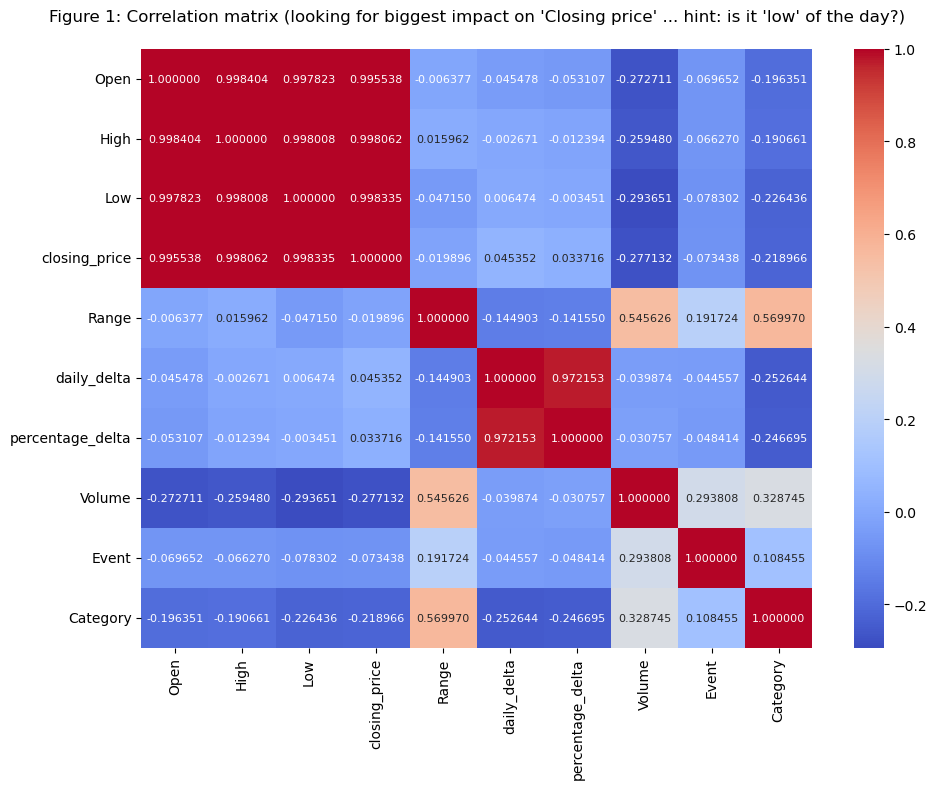

In [136]:
corr_matrix = insight_df[insight_df.columns.tolist()].corr()
# setting up the matplotlib figure
plt.figure(figsize=(10, 8))
# plotting the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".6f", annot_kws={"size": 8})
plt.title("Figure 1: Correlation matrix (looking for biggest impact on 'Closing price' ... hint: is it 'low' of the day?)", pad=20)
plt.tight_layout()
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v05.png")
plt.show()

In [111]:
# determining unique values of 'low' feature to create visualization
insight_df['Low'].unique() # it appears we have 8 possible values
# print(insight_df['cylinders_encoded'])

array([1645.51001 , 1653.329956, 1658.22998 , ..., 2062.350098,
       2017.280029, 2018.949951])

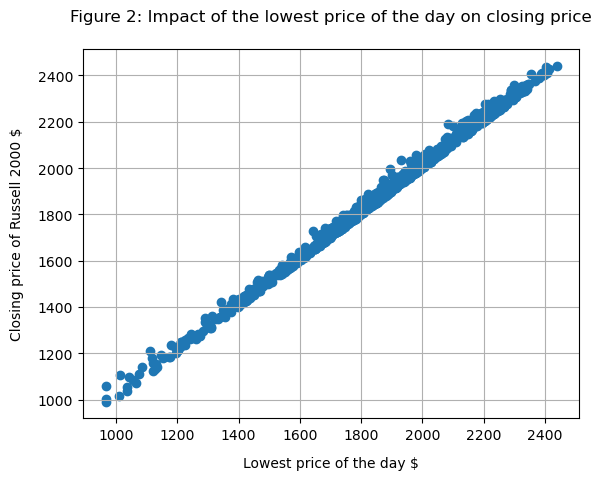

In [137]:
plt.scatter(insight_df['Low'], insight_df['closing_price'])
plt.ticklabel_format(style='plain', axis='y')
plt.title('Figure 2: Impact of the lowest price of the day on closing price', pad=20)
plt.xlabel("Lowest price of the day $", labelpad=10)
plt.ylabel("Closing price of Russell 2000 $", labelpad=10)
plt.grid()
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v06.png")

In [117]:
# scaling the data using StandardScaler(), this will simplify our Pipeline down the line
# initializing StandardScaler()
scaler = StandardScaler()
# fitting and transforming the data
scaled_data = scaler.fit_transform(insight_df)
# converting the scaled data into a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=insight_df.columns)

print("Original DataFrame: \n")
print(insight_df.head())

print("\n DataFrame after scaling using StandardScaler(): \n")
print(scaled_df.head())

Original DataFrame: 

          Open         High          Low  closing_price      Range  \
0  1650.660034  1664.849976  1645.510010    1663.260010  19.339966   
1  1659.729980  1662.099976  1653.329956    1658.310059   8.770020   
2  1658.469971  1669.290039  1658.229980    1663.589966  11.060059   
3  1669.859985  1671.819946  1663.780029    1664.989990   8.039917   
4  1665.469971  1666.750000  1654.010010    1657.640015  12.739990   

   daily_delta  percentage_delta      Volume  Event  Category  
0     2.390015          0.143901  3702460000      0         0  
1    -4.949951         -0.297605  3435910000      0         0  
2     5.279907          0.318391  3726840000      0         0  
3     1.400024          0.084157  3641230000      0         0  
4    -7.349975         -0.441443  3214580000      0         0  

 DataFrame after scaling using StandardScaler(): 

       Open      High       Low  closing_price     Range  daily_delta  \
0 -0.803887 -0.812491 -0.758081      -0.758990 -

In [118]:
# creating a dataframe with only independent variables (without 'closing_price' feature) and a series containing 'closing_price' data (target variable)
# also splitting data for cross-validation later
X = scaled_df.drop('closing_price', axis = 1)
y = scaled_df['closing_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 71)
# another neat way of splitting the data
# X_train, X_test, y_train, y_test = train_test_split(<dataframe>.drop('<target variable>', axis = 1), <dataframe>['<target variable>'], test_size = ?, random_state=42)

In [121]:
# confirming expected output

print(X_train.shape, y_train.shape)
print(' should be 80% of 1,095 - and it is! \n' )
print(X_test.shape, y_test.shape)
print(' should be 20% of 1,095 - and it is!')

(876, 9) (876,)
 should be 80% of 1,095 - and it is! 

(219, 9) (219,)
 should be 20% of 1,095 - and it is!


In [122]:
# initializing Pipeline using Ridge model
pipeline = Pipeline([('regressor', Ridge())])
pipeline

Pipeline(steps=[('regressor', Ridge())])

In [123]:
# initializing GridSearchCV() to look for the best 'alpha' parameter for Ridge model
param_grid = {'regressor__alpha': 10**np.linspace(-5, 4, 100)}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error').fit(X_train, y_train)
grid_search

GridSearchCV(cv=5, estimator=Pipeline(steps=[('regressor', Ridge())]),
             param_grid={'regressor__alpha': array([1.00000000e-05, 1.23284674e-05, 1.51991108e-05, 1.87381742e-05,
       2.31012970e-05, 2.84803587e-05, 3.51119173e-05, 4.32876128e-05,
       5.33669923e-05, 6.57933225e-05, 8.11130831e-05, 1.00000000e-04,
       1.23284674e-04, 1.51991108e-04, 1.87381742e-04, 2.31012970e-04,
       2.84...
       8.11130831e+01, 1.00000000e+02, 1.23284674e+02, 1.51991108e+02,
       1.87381742e+02, 2.31012970e+02, 2.84803587e+02, 3.51119173e+02,
       4.32876128e+02, 5.33669923e+02, 6.57933225e+02, 8.11130831e+02,
       1.00000000e+03, 1.23284674e+03, 1.51991108e+03, 1.87381742e+03,
       2.31012970e+03, 2.84803587e+03, 3.51119173e+03, 4.32876128e+03,
       5.33669923e+03, 6.57933225e+03, 8.11130831e+03, 1.00000000e+04])},
             scoring='neg_mean_squared_error')

In [124]:
# printing the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Train MSE Score:", -grid_search.best_score_)

# evaluate the final model on the test set
test_score = grid_search.score(X_test, y_test)
print("Test Set MSE Score:", -test_score)

Best Hyperparameters: {'regressor__alpha': 0.015199110829529346}
Best Train MSE Score: 0.0005476981349738904
Test Set MSE Score: 0.0005930799021069439


In [125]:
best_pipeline = grid_search.best_estimator_
best_pipeline

Pipeline(steps=[('regressor', Ridge(alpha=0.015199110829529346))])

In [126]:
ridge_regressor = best_pipeline.named_steps['regressor']
ridge_regressor

Ridge(alpha=0.015199110829529346)

In [127]:
# obtaining coefficients from the Ridge model to determine the importance of the features
coefficients = ridge_regressor.coef_
coefficients

array([ 5.75283229e-01,  2.11729266e-01,  2.11424950e-01,  1.51806450e-03,
        9.39800372e-02, -2.40025432e-02, -3.50070423e-04,  6.42256019e-04,
       -5.74236397e-04])

In [128]:
# we're now arriving to the answer to our question "What drives the price of the Russell 2000 index?" with Ridge model
coef_df_ridge = pd.DataFrame({'Feature': X.columns.tolist(), 'Coefficient': coefficients})
# coef_df
coef_df_sorted = coef_df_ridge.sort_values(by='Coefficient', ascending=False)
coef_df_sorted

,Feature,Coefficient
0,Open,0.575283
1,High,0.211729
2,Low,0.211425
4,daily_delta,0.093980
3,Range,0.001518
7,Event,0.000642
6,Volume,-0.000350
8,Category,-0.000574
5,percentage_delta,-0.024003


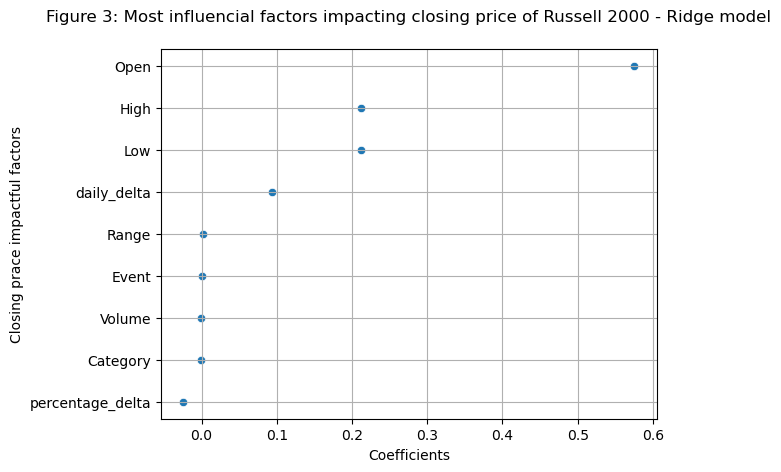

In [138]:
# plotting Ridge coefficients to visualize the impact on 'closing_price'
sns.scatterplot(data=coef_df_sorted, x='Coefficient', y='Feature' ) # make visualization using Seaborn
plt.title("Figure 3: Most influencial factors impacting closing price of Russell 2000 - Ridge model", pad=20)
plt.xlabel("Coefficients")
plt.ylabel("Closing prace impactful factors")
plt.grid()
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v07.png")
plt.show()

In [130]:
# now we will model with LinearRegression() as oppose to Ridge() above to get additional insights
# instantiating LinearRegression()
model = LinearRegression()
# fitting the model to the data splitted above
model.fit(X_train, y_train)
# making predictions ... 
predictions = model.predict(X)

# printing the coefficients and intercept
print("Coefficients:", model.coef_)  # slope(s) of the linear model
print("Intercept:", model.intercept_)  # intercept of the linear model

# printing the predictions
print("Predictions:", predictions)

Coefficients: [ 5.87922248e-01  2.05412543e-01  2.05116983e-01  1.47791305e-03
  9.48351939e-02 -2.42605640e-02 -3.53921535e-04  6.52272879e-04
 -5.40948718e-04]
Intercept: 0.0002909882982359839
Predictions: [-0.79107722 -0.78663959 -0.75660268 ...  0.66648229  0.51162981
  0.52635313]


In [131]:
# we're now arriving to the answer to our question "What drives the price of the Russell 2000 index?" with LinearRegression
coef_df_linear = pd.DataFrame({'Feature': X.columns.tolist(), 'Coefficient': model.coef_})
# coef_df
coef_df_sorted_linear = coef_df_linear.sort_values(by='Coefficient', ascending=False)
coef_df_sorted_linear

,Feature,Coefficient
0,Open,0.587922
1,High,0.205413
2,Low,0.205117
4,daily_delta,0.094835
3,Range,0.001478
7,Event,0.000652
6,Volume,-0.000354
8,Category,-0.000541
5,percentage_delta,-0.024261


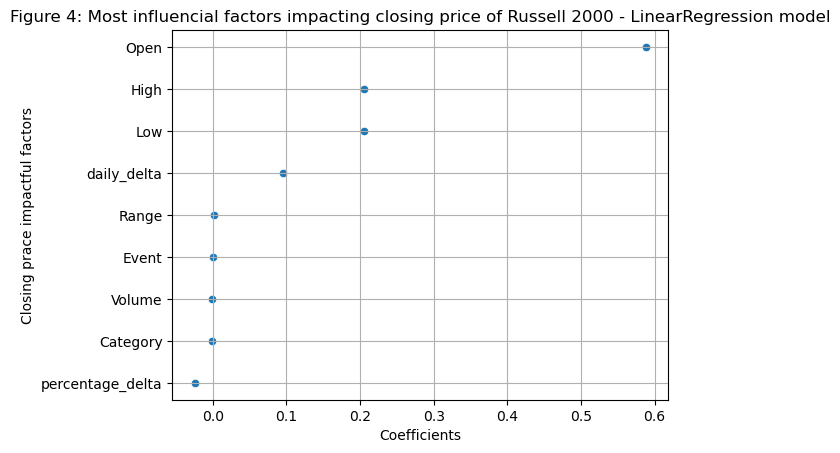

In [139]:
# plotting LinearRegression coefficients to visualize the impact on the 'closing_price'
sns.scatterplot(data=coef_df_sorted_linear, x='Coefficient', y='Feature' ) # make visualization using Seaborn
plt.title("Figure 4: Most influencial factors impacting closing price of Russell 2000 - LinearRegression model")
plt.xlabel("Coefficients")
plt.ylabel("Closing prace impactful factors")
plt.grid()
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v08.png")
plt.show()

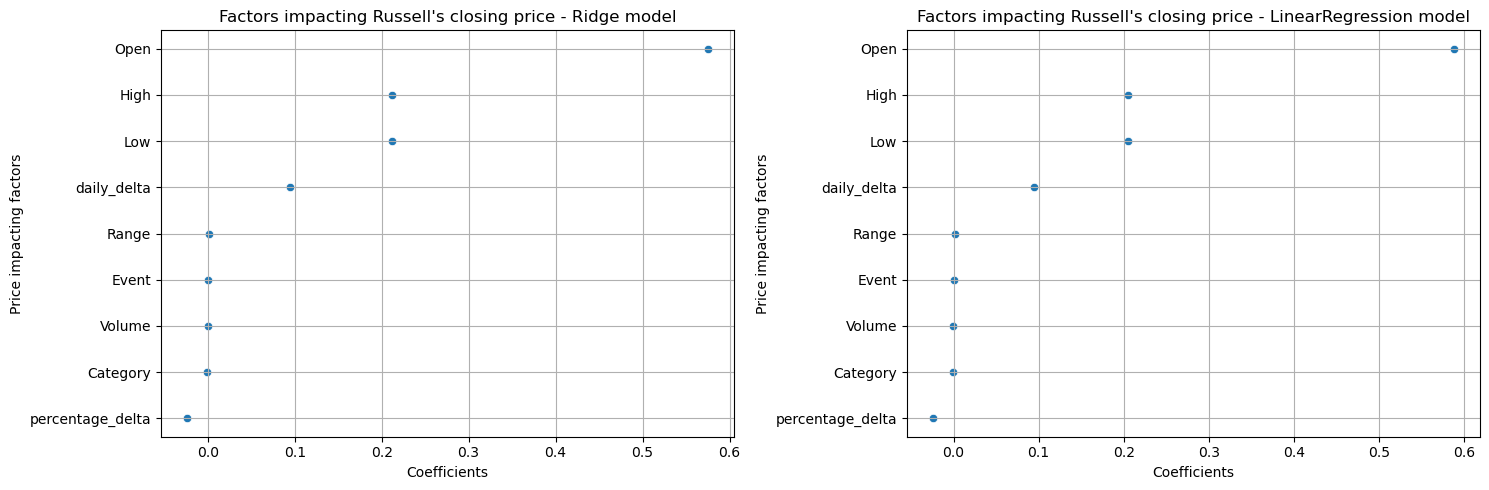

In [140]:
# side-by-side subplots note 'open' plotting of Ridge coefficient 0.575283  vs. LinearRegression coefficient 0.587922
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


# scatter plot for Ridge model
sns.scatterplot(data=coef_df_sorted, x='Coefficient', y='Feature', ax=axes[0])
axes[0].set_title("Factors impacting Russell's closing price - Ridge model")
axes[0].set_xlabel("Coefficients")
axes[0].set_ylabel("Price impacting factors")
axes[0].grid(True)

# scatter plot for LinearRegression model
sns.scatterplot(data=coef_df_sorted_linear, x='Coefficient', y='Feature', ax=axes[1])
axes[1].set_title("Factors impacting Russell's closing price - LinearRegression model")
axes[1].set_xlabel("Coefficients")
axes[1].set_ylabel("Price impacting factors")
axes[1].grid(True)

# adjusting layout
plt.tight_layout()

# showing the plot
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v09.png")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

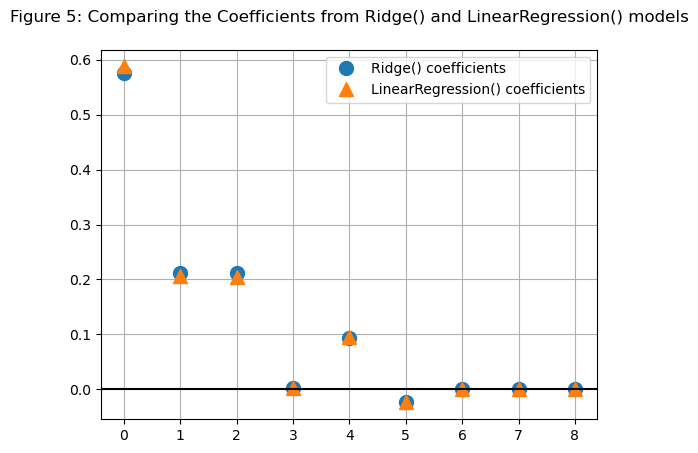

In [141]:
# side-by-side comparizon of coefficients from Ridge() and LinearRegression() models
plt.plot(ridge_regressor.coef_, 'o', markersize = 10, label = 'Ridge() coefficients')
plt.plot(model.coef_, '^', markersize = 10, label = 'LinearRegression() coefficients')
plt.legend()
plt.axhline(color = 'black')
plt.grid()
plt.title('Figure 5: Comparing the Coefficients from Ridge() and LinearRegression() models', pad=20)
plt.savefig("C:/Users/iheaven/jupiterNotebook/practicalApplication_capstone/optionsTrading_AIML_miscImage_v10.png")
plt.show